### Tải thư viện và dữ liệu

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import graphviz

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder


In [69]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print(train.shape, test.shape)
train.head()


(891, 12) (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Tiền xử lý dữ liệu

In [70]:
# Điền giá trị thiếu
train['Age'].fillna(train['Age'].median(), inplace=True)
train['Embarked'].fillna(train['Embarked'].mode()[0], inplace=True)
test['Age'].fillna(test['Age'].median(), inplace=True)
test['Fare'].fillna(test['Fare'].median(), inplace=True)
test['Embarked'].fillna(test['Embarked'].mode()[0], inplace=True)

# Encode biến phân loại
for col in ['Sex', 'Embarked']:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])
    test[col] = le.transform(test[col])

features = ['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']
X = train[features]
y = train['Survived']


C:\Users\hienm\AppData\Local\Temp\ipykernel_15620\2239564989.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['Age'].fillna(train['Age'].median(), inplace=True)
C:\Users\hienm\AppData\Local\Temp\ipykernel_15620\2239564989.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.


### Chia dữ liệu train/test

In [71]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)


### Cây quyết định cơ bản

In [72]:
dt = tree.DecisionTreeClassifier(max_depth=3, random_state=42)
dt.fit(X_train, y_train)

print("Train acc:", dt.score(X_train, y_train))
print("Val acc:", dt.score(X_val, y_val))

dot_data = tree.export_graphviz(
    dt, out_file=None, feature_names=features,
    class_names=['Died','Survived'], filled=True, rounded=True
)
graph = graphviz.Source(dot_data)
graph


Train acc: 0.8342696629213483
Val acc: 0.7988826815642458


ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

### Tối ưu tham số max_depth

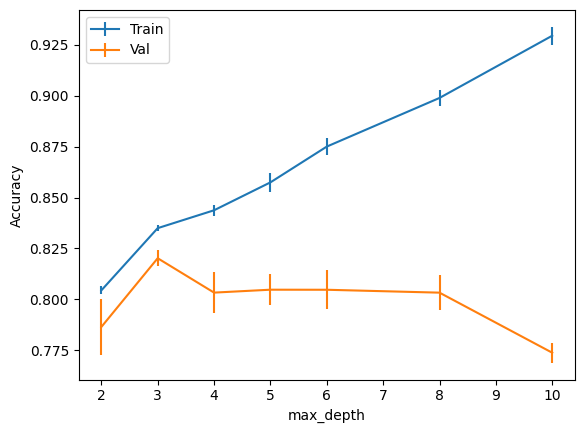

Best params: {'max_depth': 3}


In [73]:
params = {'max_depth':[2,3,4,5,6,8,10]}
cv_dt = GridSearchCV(tree.DecisionTreeClassifier(random_state=42),
                     param_grid=params, scoring='accuracy',
                     cv=5, return_train_score=True)
cv_dt.fit(X_train, y_train)

cv_results = pd.DataFrame(cv_dt.cv_results_)
plt.errorbar(cv_results['param_max_depth'], cv_results['mean_train_score'],
             yerr=cv_results['std_train_score']/np.sqrt(5), label="Train")
plt.errorbar(cv_results['param_max_depth'], cv_results['mean_test_score'],
             yerr=cv_results['std_test_score']/np.sqrt(5), label="Val")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

print("Best params:", cv_dt.best_params_)


### Rừng cây (Random Forest)

In [74]:
rf = RandomForestClassifier(random_state=42)
rf_params = {'n_estimators':[50,100,200], 'max_depth':[3,5,7,None]}
cv_rf = GridSearchCV(rf, param_grid=rf_params, scoring='accuracy',
                     cv=5, return_train_score=True)
cv_rf.fit(X_train, y_train)

print("Best params:", cv_rf.best_params_)
print("Validation acc:", cv_rf.best_score_)


Best params: {'max_depth': 5, 'n_estimators': 100}
Validation acc: 0.8300108342361863


### Độ quan trọng đặc trưng

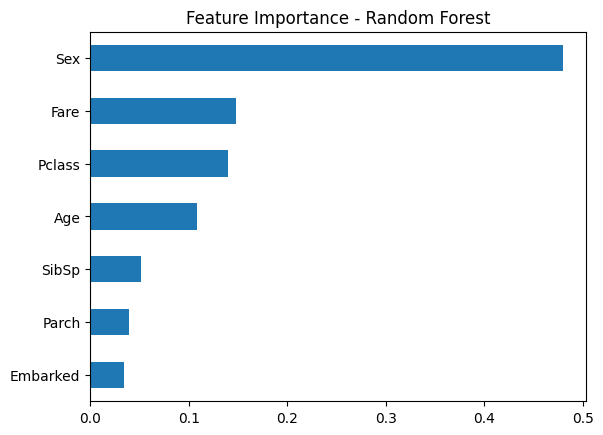

In [75]:
feat_imp = pd.Series(cv_rf.best_estimator_.feature_importances_,
                     index=features).sort_values()
feat_imp.plot(kind='barh')
plt.title("Feature Importance - Random Forest")
plt.show()
